https://www.kaggle.com/kenconstable/alzheimer-s-multi-class-classification#Alzheimers-Multiclass-Classification

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install tensorflow

In [2]:
!pip install tqdm

In [3]:
!pip install split-folders

In [4]:
!pip3 install scikit-image

**Keras Tuner**는 TensorFlow 프로그램에 대한 최적의 하이퍼파라미터 세트를 선택하는 데 도움을 주는 라이브러리입니다. 
머신러닝(ML) 애플리케이션에 대한 올바른 하이퍼파라미터 세트를 선택하는 과정을 하이퍼파라미터 조정 또는 하이퍼튜닝이라고 합니다.

하이퍼파라미터는 훈련 프로세스 및 ML 모델의 토폴로지를 제어하는 변수입니다. 
이러한 변수는 훈련 과정에서 일정하게 유지되며 ML 프로그램의 성능에 직접적으로 영향을 미칩니다. 
하이퍼파라미터에는 두 가지 유형이 있습니다.

> 1. 숨겨진 레이어의 수 및 너비와 같이 모델 선택에 영향을 미치는 모델 하이퍼파라미터
> 2. SGD(Stochastic Gradient Descent)의 학습률 및 KNN(k Nearest Neighbors) 분류자의 최근접 이웃 수와 같은 학습 알고리즘의 속도와 품질에 영향을 주는 알고리즘 하이퍼파라미터

이 튜토리얼에서는 Keras Tuner를 사용하여 이미지 분류 애플리케이션에 하이퍼튜닝을 수행합니다.

- 출처 : https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=ko

**정확도 측정**
- Accuracy : 예측이 레이블과 일치하는 빈도를 계산
- BinaryAccuracy: 예측이 이진 레이블과 일치하는 빈도를 계산
- CategoricalAccuracy : 예측이 one-hot 레이블과 일치하는 빈도를 계산

In [5]:
!pip install keras-tuner

In [1]:
# Import Libraries
import numpy as np 
import pandas as pd 
import time
import itertools

# file system libraries
import os
import os.path
from   os import path
import shutil

# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# splits train folders into train/validation with stratification
import splitfolders  

# Images, Plotting
from skimage import io
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# tensorflow - CNNs
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import backend, models, layers, Sequential
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import applications
from tensorflow.keras.applications import DenseNet121,InceptionV3, Xception, ResNet101
from kerastuner.tuners import Hyperband

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


# 경로 및 시드 지정

In [2]:
os.getcwd()

'/home/jupyter'

In [3]:
ls

'Alzheimer_s Dataset'/   README.md   brain_tensorflow.ipynb   src/
 DjangoBackend/          Ryu/        kaggle_base.ipynb        tutorials/


In [4]:
# !mkdir Ryu

In [5]:
# 주피터 노트북버전 경로
FOLDERS     = ['train','val','test']
DIR_INPUT   = './Alzheimer_s Dataset'
DIR_WORK    = './Ryu'
DIR_MODELS  = os.path.join(DIR_WORK,'models')
DIR_TRAIN   = os.path.join(DIR_WORK,'train')
DIR_VAL     = os.path.join(DIR_WORK,'val')
DIR_TEST    = os.path.join(DIR_WORK,'test')
CLASS_LIST  = ['MildDememted','ModerateDemented','NonDememted','VeryMildDemented']


# Set seeds for reproducibility 
SEED        = 1985
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [6]:
# 구글코랩 버전 경로

# FOLDERS     = ['train','val','test']
# DIR_INPUT   = '/content/drive/MyDrive/Colab_Notebooks/mentoring/brain/Alzheimer_sDataset'
# DIR_WORK    = '/content/drive/MyDrive/Colab_Notebooks/mentoring/brain/Ryu'
# DIR_MODELS  = os.path.join(DIR_WORK,'models')
# DIR_TRAIN   = os.path.join(DIR_WORK,'train')
# DIR_VAL     = os.path.join(DIR_WORK,'val')
# DIR_TEST    = os.path.join(DIR_WORK,'test')
# CLASS_LIST  = ['MildDememted','ModerateDemented','NonDememted','VeryMildDemented']


# # Set seeds for reproducibility 
# SEED        = 1985
# tf.random.set_seed(SEED)
# np.random.seed(SEED)

# Train/Test set의 각 class별 이미지 개수

In [7]:
from glob import glob

In [15]:
glob(os.path.join(DIR_WORK, '*'))

['/content/drive/MyDrive/Colab_Notebooks/mentoring/brain/Ryu/models',
 '/content/drive/MyDrive/Colab_Notebooks/mentoring/brain/Ryu/test',
 '/content/drive/MyDrive/Colab_Notebooks/mentoring/brain/Ryu/train',
 '/content/drive/MyDrive/Colab_Notebooks/mentoring/brain/Ryu/val']

In [16]:
for (a, b, c) in os.walk(os.path.join(DIR_WORK, 'train')):
    print(a)  # os.walk(root주소) : root주소 출력
#     print(b)  # root주소 안에있는 폴더들 출력
#     print(c)  # b에서 출력된 폴더 하위의 파일들 출력
#     for file in c:
#         print(a)

/content/drive/MyDrive/Colab_Notebooks/mentoring/brain/Ryu/train
/content/drive/MyDrive/Colab_Notebooks/mentoring/brain/Ryu/train/VeryMildDemented
/content/drive/MyDrive/Colab_Notebooks/mentoring/brain/Ryu/train/ModerateDemented
/content/drive/MyDrive/Colab_Notebooks/mentoring/brain/Ryu/train/MildDemented
/content/drive/MyDrive/Colab_Notebooks/mentoring/brain/Ryu/train/NonDemented


In [8]:
def images_by_class(path, folders):
    """
    Loop through the path/folders count the number and proportions of each class
    """

    # accumulators
    normal, verymild, mild, moderate = 0, 0, 0, 0

    # print header
    msg = '{:8} {:8} {:11} {:7} {:9} {:9} {:11} {:8} {:8}'.format('folder', 'normal', 'verymild', 'mild', 'moderate',
                                                                  'normal %', 'verymild %', 'mild %', 'moderate %')
    print(msg)
    print("-"*len(msg))

    # FOLDERS = ['train','val','test'] 
    for folder in FOLDERS:
        # dirname은 os.path.join(path, folder) 이므로 각 train/val/test의 폴더 주소
        # filesnames는 각 이미지
        # filesnames는 dirname에 귀속되어있으므로 각 filesnames의 dirname에 어떤 class가 존재하는지를 count
        for dirname, _, filenames in os.walk(os.path.join(path, folder)):
            for file in filenames:
                if "NonDemented" in dirname:
                    normal += 1
                if "VeryMildDemented" in dirname:
                    verymild += 1
                if 'MildDemented' in dirname:
                    mild += 1
                if 'ModerateDemented' in dirname:
                    moderate += 1

        # 각 클래스별 이미지비율 계산
        total = normal+verymild+mild+moderate
        if total > 0:
            n = round(normal/total, 2)*100
            vm = round(verymild/total, 2)*100
            m = round(mild/total, 2)*100
            mo = round(moderate/total, 2)*100
        else:
            n, vm, m, mo = 0, 0, 0, 0

        print("{:6} {:8} {:10} {:7} {:11} {:8} {:10} {:8} {:12}".format(
            folder, normal, verymild, mild, moderate, n, vm, m, mo))
        normal, verymild, mild, moderate = 0, 0, 0, 0

In [9]:
# Images by class in the input directory
images_by_class(DIR_INPUT,FOLDERS) 

folder   normal   verymild    mild    moderate  normal %  verymild %  mild %   moderate %
-----------------------------------------------------------------------------------------
train      2560       1792    2509          52     37.0       26.0     36.0          1.0
val           0          0       0           0        0          0        0            0
test        640        448     627          12     37.0       26.0     36.0          1.0


# 디렉토리 생성

In [10]:
# create a new directory if it doesn't exist
def create_dir(dir_path,folder,verbose=True):
    """
    dir_path/folder 경로가 존재하지 않으면 생성
    """
    msg = ""
    folder_path = os.path.join(dir_path,folder)
    
    if not path.exists(folder_path):
        try:
            os.mkdir(folder_path)
            msg = folder_path + ' created'
        except OSError as err:
            print('Error creating folder:{} with error:{}'.format(folder_path,err))
    if verbose:
        print(msg)
        
    return folder_path

In [14]:
# models 폴더 추가
create_dir(DIR_WORK,'models',True)

./Ryu/models created


'./Ryu/models'

# Train/Validation Set 나누기

In [11]:
def resample_train_val_images(input_dir,working_dir,seed=SEED,split = (0.70,0.30)):
    """
    train의 이미지를 train/validation으로 나누고 사용할 폴더위치를 바꿈
    """
    # 기존의 train/test 폴더 존재하는 경로
    dir_test   = os.path.join(input_dir,'test')
    dir_train  = os.path.join(input_dir,'train')
    

    # FOLDERS = ['train','val','test']
    # 만약에 이미 폴더가 존재하면 삭제
    # shutil.rmtree('경로') : 지정된 폴더와 하위 디렉토리 폴더, 파일를 모두 삭제
    for folder in FOLDERS:
        if path.exists(os.path.join(working_dir,folder)):
            shutil.rmtree(os.path.join(working_dir,folder))

            
    # shutil.copytree("./test1", "./test2") : test1 폴더에 들어있는 파일과 폴더를 test2에 복사.
                                            # test2 폴더는 기존에 존재하지 않은 폴더로 copytree 함수가 실행될때 새로 만들어짐. 이미 있다면 에러
    # https://ponyozzang.tistory.com/439
    shutil.copytree(dir_test, os.path.join(working_dir,'test'))
    
     # train/validation set을 나눔
        # https://lynnshin.tistory.com/46
    splitfolders.ratio(dir_train, working_dir, seed=seed, ratio=split) 
        
    # 
    print("\n Images By Class After Resampling")
    print("-"*67)
    images_by_class(working_dir,FOLDERS)

In [12]:
resample_train_val_images(DIR_INPUT,DIR_WORK)

Copying files: 5121 files [00:00, 11948.27 files/s]


 Images By Class After Resampling
-------------------------------------------------------------------
folder   normal   verymild    mild    moderate  normal %  verymild %  mild %   moderate %
-----------------------------------------------------------------------------------------
train      1792       1254    1755          36     37.0       26.0     36.0          1.0
val         768        538     754          16     37.0       26.0     36.0          1.0
test        640        448     627          12     37.0       26.0     36.0          1.0


# 이미지 전처리

In [13]:
# 이미지크기 / batch size 설정
IMG_SIZE = [176,208]
BATCH_SIZE = 64

In [14]:
# 이미지 각 픽셀들 정규화
train_images = ImageDataGenerator(rescale  = 1./255)
val_images   = ImageDataGenerator(rescale  = 1./255)
test_images  = ImageDataGenerator(rescale  = 1./255)

In [15]:
# 데이터셋 생성

# train images: 4098
train_gen =train_images.flow_from_directory(
    DIR_TRAIN,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',   
    # color_mode  = 'grayscale',      
    seed        = SEED 
)

# validation images: 1023
val_gen = val_images.flow_from_directory(
    DIR_VAL,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',         
    # color_mode  = 'grayscale', 
    seed        = SEED
)

# test images:1279
test_gen = test_images.flow_from_directory(
    DIR_TEST,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',       
    # color_mode  = 'grayscale', 
    seed        = SEED,
    shuffle     = False
)

Found 3583 images belonging to 4 classes.
Found 1538 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [16]:
# train/val set의 각 epoch당 step 수
steps_per_epoch  = train_gen.n // train_gen.batch_size
print("steps per epoch:{}".format(steps_per_epoch))

steps per epoch:55


# 각 이미지를 라벨과 함께 시각화하여 확인

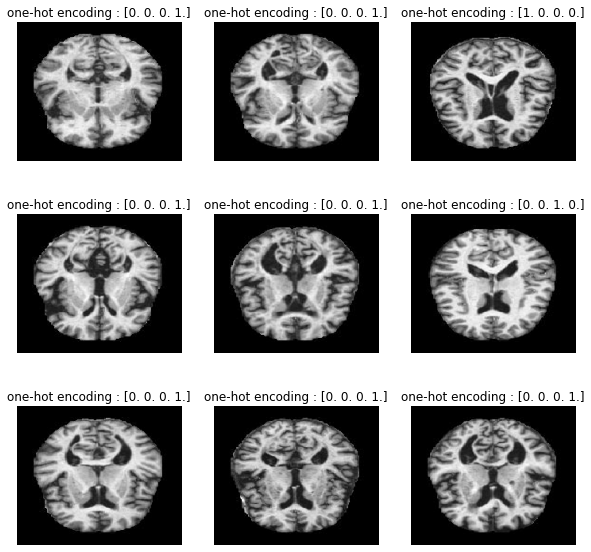

In [17]:
a, b = train_gen.next()

plt.figure(figsize=(10, 10))
for i in range(9):
#     print(b[i])
#     print(np.argmax(b[i]))
    ax = plt.subplot(3,3,i+1)
    plt.imshow(a[i])
    plt.axis("off")
    plt.title('one-hot encoding : {}'.format(b[i]))
#     plt.show()
    

In [18]:
def show_images(generator,y_pred=None):
    """
    Input: image generator(train_gen, val_gen, test_gen), y_pred=예상 라벨 (안 넣어도 됨)
    Output: 9개의 이미지를 라벨과 함께 보여줌
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASS_LIST))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[i])]))
            
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))

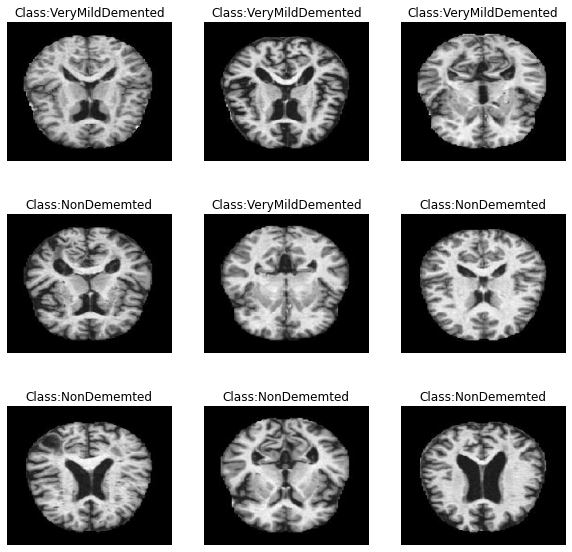

In [19]:
show_images(train_gen)

# 전이학습을 위한 모델의 기초뼈대 생성

In [20]:
def build_transfer_model(conv_base, dropout, conv_nodes, dense_node, learn_rate, metric):
    """
    전이학습을 위한 모델의 뼈대형성

    Input : 
        conv_base : 전이학습 모델
        dropout : dropout비율
        conv_nodes :  Conv2D layer의 노드 개수
        dense_node : 마지막 Dense layer의 node 개수
        learn_rate : 학습비율
        metric : 평가지표

    Output: 컴파일된 전이모델
    """

    # clear previous run
    backend.clear_session()

    # build the model
    model = Sequential()
    model.add(conv_base)
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Conv2D(conv_nodes, 3, padding='same', activation='relu'))
    model.add(Conv2D(conv_nodes, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout + 0.10))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(dense_node,activation='relu'))
    model.add(Dense(4,activation='softmax'))


    # complile the model
    model.compile(
        optimizer = tensorflow.keras.optimizers.Adam(lr=learn_rate),
        loss      = 'categorical_crossentropy', 
        metrics   = metric )
    
    model.summary()
    return model

In [21]:
def freeze_layers(base,conv_num="conv5",block_num=1,max_block_num=16,trainable_layers='some'):
    """
    Input: A base transferable model,the layer name, the block number, the max number of blocks
           The layer name, block number and max of blocks only works with DenseNet121
    Output:Sets all layers to trainable from conv#_block_num to conv#_max_block_num
    
    """
    # https://www.tensorflow.org/guide/keras/transfer_learning?hl=ko
    # base.trainable = False : 모든 레이어의 가중치가 훈련 가능에서 훈련 불가능으로 이동
                            # 훈련 가능한 가중치가 훈련할 수 없게 되면 훈련 중에 그 값이 더는 업데이트되지 않는다.
    
    if trainable_layers=='none':
        base.trainable = False
        print("No Layers Trainable: Using Base Model Weights")
    if trainable_layers=='all':
        base.trainable =True
        print("All Layers Trainable: Base Model will be fully trained")
    
    if trainable_layers=='some':
        
        print("Some Layers of the Model will be Trainable:")
        print("---------------------------------------------")
        
        
         # 전이학습 모델의 가중치학습 동결
        base.trainable = False

        # conv#_block# 형태의 이름의 layer들은 학습가능한 가중치로 바꿈
        print('layer','\t\t\t','trainable')
        for block in range(block_num,max_block_num+1):
            for layer in conv_base.layers:
                if block>=block_num:
                    if conv_num +"_block"+str(block) in layer.name:
                        layer.trainable = True
                        print(layer.name,'\t',layer.trainable)

# Training Model 생성 및 학습

In [ ]:
# 파라미터 값 지정
# EPOCHS        = 15
# early_stoping = EarlyStopping(monitor = 'val_auc',patience = 10,restore_best_weights=True)

# callbacks     = [early_stoping]
# metrics       = [tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Accuracy(name='accuracy')]

In [ ]:
# 학습에 필요한 파라미터
EPOCHS        = 150
early_stoping = EarlyStopping(monitor = 'val_auc',patience = 15,restore_best_weights=True)
reduce_lr     = ReduceLROnPlateau(monitor='val_auc',factor=0.9, patience=15, min_lr=1e-20, verbose=1, cooldown=3)
callbacks     = [reduce_lr]
metrics       = [tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Accuracy(name='accuracy')]

In [ ]:
conv_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))
for block in range(1, 16):
    for layer in conv_base.layers:
        if 'conv5' + '_block' + str(block) in layer.name:
            print(layer.name)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
# 모델 형성
# 전이학습할 모델(InceptionV3)
# Train Model: Base + Optimized Hyperparameters + Data Augmentation
conv_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model = build_transfer_model(conv_base,dropout=0.5,conv_nodes=1024,dense_node =1024,learn_rate=0.001,metric=metrics)


# 학습
tic = time.perf_counter()
history = model.fit(
    train_gen,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
    callbacks        = callbacks  # early stopping 
)

# 모델 저장
model.save(os.path.join(DIR_MODELS,'model_added_layer'))

# 학습에 걸린 시간
toc = time.perf_counter()
print("Total Time:{} mins".format(round((toc-tic)/60,2)))

No Layers Trainable: Using Base Model Weights


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 5, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 4, 5, 2048)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 5, 2048)        8192      
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 5, 1024)        18875392  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 5, 1024)        9438208   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 1024)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 1024)        0

## 모델 평가

In [22]:
def plot_training_metrics(train_hist,model,test_gen,y_actual,y_pred,classes):
    """
    Input
        train_hist : 학습한 모델 결과
        model : 학습한 모델
        test_gen : 테스트 데이터셋
        y_actual : 테스트 데이터셋의 실제 라벨
        y_pred : 모델이 예측한 테스트 데이터셋의 라벨
        classes : 라벨의 class 리스트
    
    Output: Plots loss vs epochs, accuracy vs epochs, confusion matrix
        평가지표 loss의 epoch별 train/val 그래프
        평가지표 auc의 epoch별 train/val 그래프
        confusion matrix
    """
    
    # 테스트 셋을 이용해서 모델평가
    test_loss, test_metric_auc, test_metric_acc = model.evaluate(test_gen,verbose = False)
    results_auc       = round(test_metric_auc, 2)*100 
    results_acc       = round(test_metric_acc, 2)*100
#     results_f1        = round(test_metric_f1, 2)*100
    results_title_auc ="\n Model AUC on Test Data:{}%".format(results_auc)
    results_title_acc ="\n Model ACCURACY on Test Data:{}%".format(results_acc)
#     results_title_f1  ='\n Model F1 on Test Data:{}%'.format(results_f1)
    print(results_title_auc.format(results_auc))
    print(results_title_acc.format(results_acc))
#     print(results_title_f1.format(results_f1))
    print(len(results_title_acc) * "-")
    
    # print classification report
    print(classification_report(y_actual, y_pred, target_names=classes))
    
     # extract data from training history for plotting
    history_dict    = train_hist.history
    loss_values     = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    auc_values      = history_dict['auc']
    val_auc_values  = history_dict['val_auc']
    acc_values      = history_dict['accuracy']
    val_acc_values  = history_dict['val_accuracy']
    # f1_values       = history_dict['f1score']
    # val_f1_values   = history_dict['val_f1score']
    epochs          = range(1, len(history_dict['auc']) + 1)

    # get the min loss and max accuracy for plotting
    max_auc = np.max(val_auc_values)
    min_loss = np.min(val_loss_values)
    
    # create plots
    plt.subplots(figsize=(16,4))
    
    # plot loss by epochs
    plt.subplot(1,4,1)
    plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss_values, 'cornflowerblue', label = 'Validation loss')
    plt.title('Validation Loss by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.axhline(y=min_loss,color='darkslategray', linestyle='--')
    plt.legend()

    # plot AUC by epochs
    plt.subplot(1,4,2)
    plt.plot(epochs, auc_values, 'bo',label = 'Training AUC')
#     plt.plot(epochs, f1_values, 'bo',label = 'Training F1')
    plt.plot(epochs, val_auc_values, 'cornflowerblue', label = 'Validation AUC')
#     plt.plot(epochs, val_f1_values, 'cornflowerblue', label = 'Validation F1')
    plt.plot(epochs,[results_auc/100]*len(epochs),'darkmagenta',linestyle = '--',label='Test AUC')
#     plt.plot(epochs,[results_f1/100]*len(epochs),'darkmagenta',linestyle = '--',label='Test F1')
    plt.title('Validation AUC by Epochs')
#     plt.title('Validation F1 by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
#     plt.ylabel('F1')
    plt.axhline(y=max_auc,color='darkslategray', linestyle='--')
    plt.legend()

    
    # plot accuracy by epochs
    plt.subplot(1,4,3)
    plt.plot(epochs, acc_values, 'bo',label = 'Training ACCURACY')
    plt.plot(epochs, val_acc_values, 'cornflowerblue', label = 'Validation ACCURACY')
    plt.plot(epochs,[results_acc/100]*len(epochs),'darkmagenta',linestyle = '--',label='Test ACCURACY')
    plt.title('Validation ACCURACY by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('ACCURACY')
    plt.axhline(y=max_auc,color='darkslategray', linestyle='--')
    plt.legend()
    
    
    # calculate Confusion Matrix
    cm = confusion_matrix(y_actual, y_pred)

    # create confusion matrix plot
    plt.subplot(1,4,4)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title("Confusion Matrix \n AUC:{}%".format(results_auc))
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # loop through matrix, plot each 
    threshold = cm.max() / 2.
    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    


 Model AUC on Test Data:83.0%

 Model ACCURACY on Test Data:5.0%
----------------------------------
              precision    recall  f1-score   support

        mild       0.61      0.44      0.51       179
    moderate       1.00      0.17      0.29        12
      normal       0.77      0.66      0.71       640
   very-mild       0.54      0.72      0.62       448

    accuracy                           0.65      1279
   macro avg       0.73      0.50      0.53      1279
weighted avg       0.67      0.65      0.65      1279



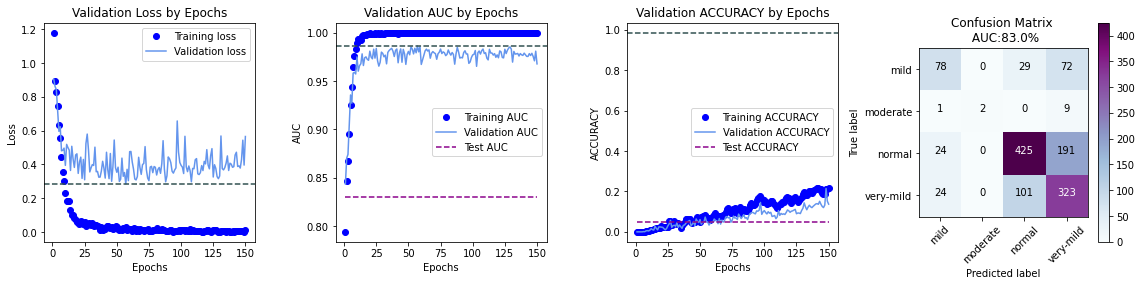

In [ ]:
# get class predictions
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot
plot_training_metrics(history,model,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])

# 이미지 증식

In [ ]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

In [ ]:
for (a, b, c) in os.walk(os.path.join(DIR_INPUT, 'train')):
#     print(a)  # os.walk(root주소) : root주소 출력
#     print(b)  # root주소 안에있는 폴더들 출력
#     print(c)  # b에서 출력된 폴더 하위의 파일들 출력
    for file in c:
        print(type(a))
#         for root in a:
#             print(root)
#             print(os.path.join(root, c))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

In [ ]:
path_ex = './Alzheimer_s Dataset/train/VeryMildDemented/verymildDem1715.jpg'
print('/'.join(path_ex.split('/')[:-1]))


./Alzheimer_s Dataset/train/VeryMildDemented


In [ ]:
# 원본파일에 잘못저장된 파일들 삭제
for path_list in glob(os.path.join(DIR_INPUT, 'train', '*', '*')):
#     print(path_list)
    if 'tri' in path_list:
        print(path_list)
#         os.remove(path_list)


In [ ]:
for img_path in glob(os.path.join(DIR_TRAIN, '*', '*')):
    print(img_path)
    img_dir_path = '/'.join(img_path.split('/')[:-1])
    print(img_dir_path)
    img=load_img(img_path)
    x=img_to_array(img)  # 이미지를 array로 변경 
    x=x.reshape((1,)+x.shape) # img를 4차원으로 
    print(x.shape)

#     이미지 증식 
    i=0
    for batch in train_images_au.flow(x,batch_size=1, save_to_dir=img_dir_path, save_prefix="tri",save_format="jpg"):
        print(img_dir_path)
        i+=1
        if i > 2:
            break

./Ryu/train/VeryMildDemented/verymildDem1715.jpg
./Ryu/train/VeryMildDemented
(1, 208, 176, 3)
./Ryu/train/VeryMildDemented
./Ryu/train/VeryMildDemented
./Ryu/train/VeryMildDemented
./Ryu/train/VeryMildDemented/verymildDem459.jpg
./Ryu/train/VeryMildDemented
(1, 208, 176, 3)
./Ryu/train/VeryMildDemented
./Ryu/train/VeryMildDemented
./Ryu/train/VeryMildDemented
./Ryu/train/VeryMildDemented/verymildDem1700.jpg
./Ryu/train/VeryMildDemented
(1, 208, 176, 3)
./Ryu/train/VeryMildDemented
./Ryu/train/VeryMildDemented
./Ryu/train/VeryMildDemented
./Ryu/train/VeryMildDemented/verymildDem686.jpg
./Ryu/train/VeryMildDemented
(1, 208, 176, 3)
./Ryu/train/VeryMildDemented
./Ryu/train/VeryMildDemented
./Ryu/train/VeryMildDemented
./Ryu/train/VeryMildDemented/verymildDem1029.jpg
./Ryu/train/VeryMildDemented
(1, 208, 176, 3)
./Ryu/train/VeryMildDemented
./Ryu/train/VeryMildDemented
./Ryu/train/VeryMildDemented
./Ryu/train/VeryMildDemented/verymildDem1031.jpg
./Ryu/train/VeryMildDemented
(1, 208, 176, 

In [ ]:
    # 이미지 증식 
#     i=0
#     for batch in train_images_au.flow(x,batch_size=1, save_to_dir='store', save_prefix="tri",save_format="png"):
#         i+=1
#         if i > 2:
#             break

# Train Data Set Augmentation 했을때의 모델 학습

In [23]:
# Data Augmentation on training images
train_images_au = ImageDataGenerator(rescale            = 1./255,
                                  rotation_range     = 5,
                                  zoom_range         = 0.10,
                                  brightness_range   = [0.8, 1.2],
                                  width_shift_range  =0.05,
                                  height_shift_range =0.05)

Found 3583 images belonging to 4 classes.


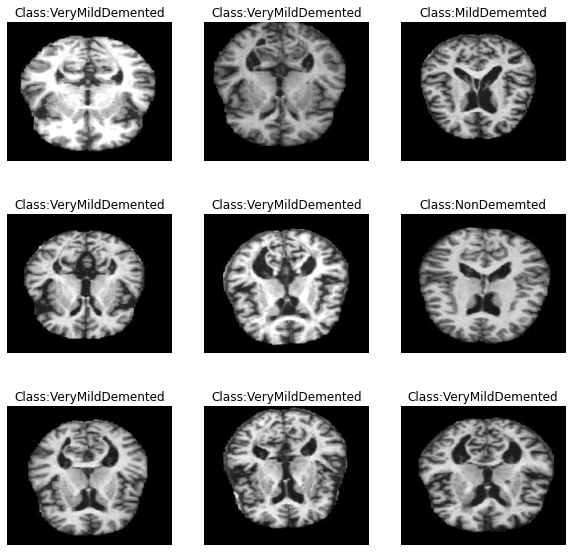

In [24]:
# train image generator
train_gen_au =train_images_au.flow_from_directory(
    DIR_TRAIN,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',
    # color_mode  = 'grayscale',          
    seed        = SEED 
)

show_images(train_gen_au)

In [ ]:
# 모델 형성
# 전이학습할 모델(InceptionV3)
# Train Model: Base + Optimized Hyperparameters + Data Augmentation
conv_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model_au = build_transfer_model(conv_base,dropout=0.5,conv_nodes=1024,dense_node =1024,learn_rate=0.001,metric=metrics)


# 학습
tic = time.perf_counter()
history_au = model_au.fit(
    train_gen_au,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
    callbacks        = callbacks  # early stopping 
)

# 모델 저장
model_au.save(os.path.join(DIR_MODELS,'model_added_augmentation'))

# 학습에 걸린 시간
toc = time.perf_counter()
print("Total Time:{} mins".format(round((toc-tic)/60,2)))

No Layers Trainable: Using Base Model Weights


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 5, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 4, 5, 2048)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 5, 2048)        8192      
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 5, 1024)        18875392  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 5, 1024)        9438208   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 1024)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 1024)        0


 Model AUC on Test Data:87.0%

 Model ACCURACY on Test Data:4.0%
----------------------------------
              precision    recall  f1-score   support

        mild       0.61      0.45      0.52       179
    moderate       1.00      0.17      0.29        12
      normal       0.72      0.84      0.77       640
   very-mild       0.65      0.58      0.62       448

    accuracy                           0.69      1279
   macro avg       0.75      0.51      0.55      1279
weighted avg       0.68      0.69      0.68      1279



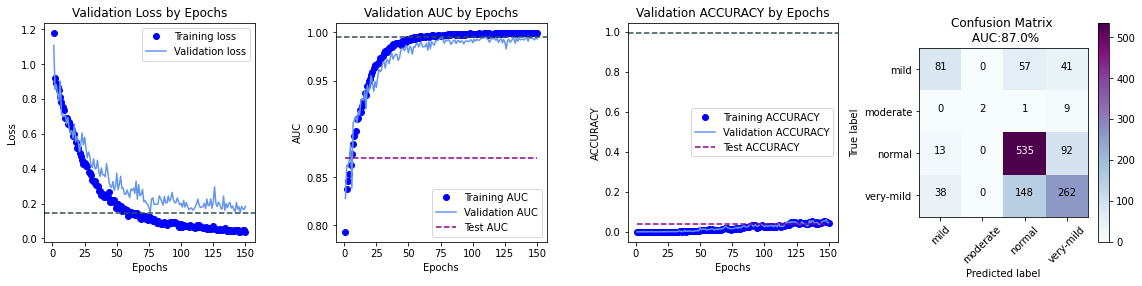

In [ ]:
# get class predictions
y_prob = model_au.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot
plot_training_metrics(history_au,model_au,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])

# 평가지표 및 콜백 수정

In [25]:
def build_transfer_model(conv_base, dropout, conv_nodes, dense_node, learn_rate, metric):
    """
    전이학습을 위한 모델의 뼈대형성

    Input : 
        conv_base : 전이학습 모델
        dropout : dropout비율
        conv_nodes :  Conv2D layer의 노드 개수
        dense_node : 마지막 Dense layer의 node 개수
        learn_rate : 학습비율
        metric : 평가지표

    Output: 컴파일된 전이모델
    """

    # clear previous run
    backend.clear_session()

    # build the model
    model = Sequential()
    model.add(conv_base)
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Conv2D(conv_nodes, 3, padding='same', activation='relu'))
    model.add(Conv2D(conv_nodes, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout + 0.10))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(dense_node,activation='relu'))
    model.add(Dense(4,activation='softmax'))


    # complile the model
    model.compile(
        optimizer = tensorflow.keras.optimizers.Adam(lr=learn_rate),
        loss      = 'categorical_crossentropy', 
        metrics   = metric )
    
    model.summary()
    return model

In [25]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

In [ ]:
# 학습에 필요한 파라미터
EPOCHS        = 100
early_stoping = EarlyStopping(monitor = 'val_auc',patience = 15,restore_best_weights=True)
reduce_lr     = ReduceLROnPlateau(monitor='val_auc',factor=0.9, patience=15, min_lr=1e-20, verbose=1, cooldown=3)
callbacks     = [early_stoping]
metrics       = [tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.CategoricalAccuracy(name='accuracy')]

In [ ]:
# 모델 형성
# 전이학습할 모델(InceptionV3)
# Train Model: Base + Optimized Hyperparameters + Data Augmentation
conv_base = InceptionV3(weights = None, include_top = False, input_shape = (*IMG_SIZE, 1))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model_au = build_transfer_model(conv_base,dropout=0.5,conv_nodes=1024,dense_node =1024,learn_rate=0.001,metric=metrics)


# 학습
tic = time.perf_counter()
history_au = model_au.fit(
    train_gen_au,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
    callbacks        = callbacks  # early stopping 
)

# 모델 저장
model_au.save(os.path.join(DIR_MODELS,'model_added_callback'))

# 학습에 걸린 시간
toc = time.perf_counter()
print("Total Time:{} mins".format(round((toc-tic)/60,2)))

In [ ]:
# get class predictions
y_prob = model_au.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot
plot_training_metrics(history_au,model_au,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])


# F1/Recall/Precision 함수정의

- 출처 : https://m.blog.naver.com/wideeyed/221226716255

In [ ]:
from keras import backend as K

In [ ]:
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall

In [ ]:
def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision

In [ ]:
def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [34]:
def build_transfer_model(conv_base, dropout, conv_nodes, dense_node, learn_rate, metric):
    """
    전이학습을 위한 모델의 뼈대형성

    Input : 
        conv_base : 전이학습 모델
        dropout : dropout비율
        conv_nodes :  Conv2D layer의 노드 개수
        dense_node : 마지막 Dense layer의 node 개수
        learn_rate : 학습비율
        metric : 평가지표

    Output: 컴파일된 전이모델
    """

    # clear previous run
    backend.clear_session()

    # build the model
    model = Sequential()
    model.add(conv_base)
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Conv2D(conv_nodes, 3, padding='same', activation='relu'))
    model.add(Conv2D(conv_nodes, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout + 0.10))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(dense_node,activation='relu'))
    model.add(Dense(4,activation='softmax'))


    # complile the model
    model.compile(
        optimizer = tensorflow.keras.optimizers.Adam(lr=learn_rate),
        loss      = 'categorical_crossentropy', 
        metrics   = metric )
    
    model.summary()
    return model

In [35]:
# 학습에 필요한 파라미터
EPOCHS        = 150
early_stoping = EarlyStopping(monitor = 'val_loss',patience = 15,restore_best_weights=True)
reduce_lr     = ReduceLROnPlateau(monitor='val_auc',factor=0.9, patience=15, min_lr=1e-20, verbose=1, cooldown=3)
callbacks     = [reduce_lr]
metrics       = [tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.CategoricalAccuracy(name='accuracy')]

In [36]:
# 모델 형성
# 전이학습할 모델(InceptionV3)
# Train Model: Base + Optimized Hyperparameters + Data Augmentation
conv_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model_au = build_transfer_model(conv_base,dropout=0.5,conv_nodes=1024,dense_node =1024,learn_rate=0.005,metric=metrics)


# 학습
tic = time.perf_counter()
history_au = model_au.fit(
    train_gen_au,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
    callbacks        = callbacks  # early stopping 
)

# 모델 저장
model_au.save(os.path.join(DIR_MODELS,'model_added_aug'))

# 학습에 걸린 시간
toc = time.perf_counter()
print("Total Time:{} mins".format(round((toc-tic)/60,2)))

87924736/87910968 [==============================] - 1s 0us/step
No Layers Trainable: Using Base Model Weights


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 5, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 4, 5, 2048)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 5, 2048)        8192      
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 5, 1024)        18875392  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 5, 1024)        9438208   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 1024)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 1024)        0


 Model AUC on Test Data:87.0%

 Model ACCURACY on Test Data:66.0%
-----------------------------------
              precision    recall  f1-score   support

        mild       0.53      0.34      0.41       179
    moderate       0.67      0.33      0.44        12
      normal       0.72      0.77      0.74       640
   very-mild       0.61      0.64      0.62       448

    accuracy                           0.66      1279
   macro avg       0.63      0.52      0.56      1279
weighted avg       0.65      0.66      0.65      1279



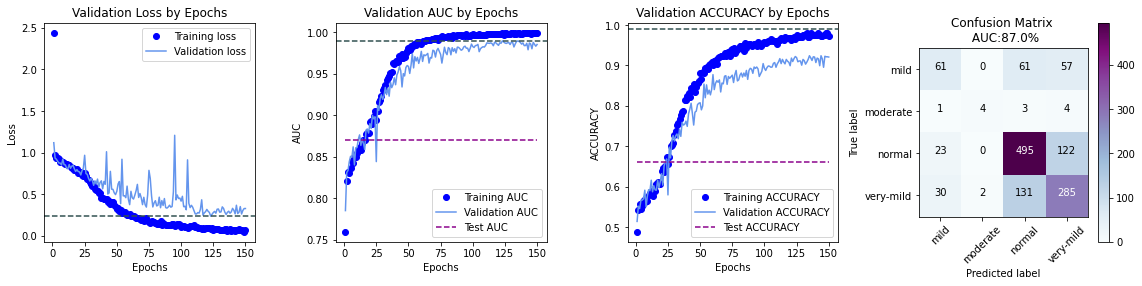

In [39]:
# get class predictions
y_prob = model_au.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot
plot_training_metrics(history_au,model_au,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])


In [31]:
# 학습에 필요한 파라미터
EPOCHS        = 150
early_stoping = EarlyStopping(monitor = 'val_loss',patience = 15,restore_best_weights=True)
reduce_lr     = ReduceLROnPlateau(monitor='val_accuracy',factor=0.9, patience=15, min_lr=1e-20, verbose=1, cooldown=3)
callbacks     = [reduce_lr]
metrics       = [tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.CategoricalAccuracy(name='accuracy')]

In [32]:
# 모델 형성
# 전이학습할 모델(InceptionV3)
# Train Model: Base + Optimized Hyperparameters + Data Augmentation
conv_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model_au = build_transfer_model(conv_base,dropout=0.5,conv_nodes=2048,dense_node =2048,learn_rate=0.002,metric=metrics)


# 학습
tic = time.perf_counter()
history_au = model_au.fit(
    train_gen_au,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
    callbacks        = callbacks  # early stopping 
)

# 모델 저장
model_au.save(os.path.join(DIR_MODELS,'model_added_nodes'))

# 학습에 걸린 시간
toc = time.perf_counter()
print("Total Time:{} mins".format(round((toc-tic)/60,2)))

No Layers Trainable: Using Base Model Weights
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 5, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 4, 5, 2048)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 5, 2048)        8192      
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 5, 2048)        37750784  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 5, 2048)        37750784  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 2048)        0         
_________________________________________________________________
dropout_1 

KeyboardInterrupt: 

In [ ]:
# get class predictions
y_prob = model_au.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot
plot_training_metrics(history_au,model_au,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])

# MobileNetV2 전이학습

In [33]:
# 모델 형성
# 전이학습할 모델(InceptionV3)
# Train Model: Base + Optimized Hyperparameters + Data Augmentation
conv_base = tf.keras.applications.mobilenet_v2.MobileNetV2(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model_au = build_transfer_model(conv_base,dropout=0.5,conv_nodes=1024,dense_node =1024,learn_rate=0.002,metric=metrics)


# 학습
tic = time.perf_counter()
history_au = model_au.fit(
    train_gen_au,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
    callbacks        = callbacks  # early stopping 
)

# 모델 저장
model_au.save(os.path.join(DIR_MODELS,'model_base_mobilenetv2'))

# 학습에 걸린 시간
toc = time.perf_counter()
print("Total Time:{} mins".format(round((toc-tic)/60,2)))

9420800/9406464 [==============================] - 0s 0us/step
No Layers Trainable: Using Base Model Weights
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 6, 7, 1280)        2257984   
_________________________________________________________________
dropout (Dropout)            (None, 6, 7, 1280)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 7, 1280)        5120      
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 7, 1024)        11797504  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 7, 1024)        9438208   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 1024)        0         
_____________

INFO:tensorflow:Assets written to: ./Ryu/models/model_base_mobilenetv2/assets


INFO:tensorflow:Assets written to: ./Ryu/models/model_base_mobilenetv2/assets
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Total Time:195.43 mins



 Model AUC on Test Data:80.0%

 Model ACCURACY on Test Data:61.0%
-----------------------------------
              precision    recall  f1-score   support

        mild       0.54      0.29      0.38       179
    moderate       1.00      0.08      0.15        12
      normal       0.61      0.90      0.72       640
   very-mild       0.67      0.35      0.46       448

    accuracy                           0.61      1279
   macro avg       0.70      0.41      0.43      1279
weighted avg       0.62      0.61      0.58      1279



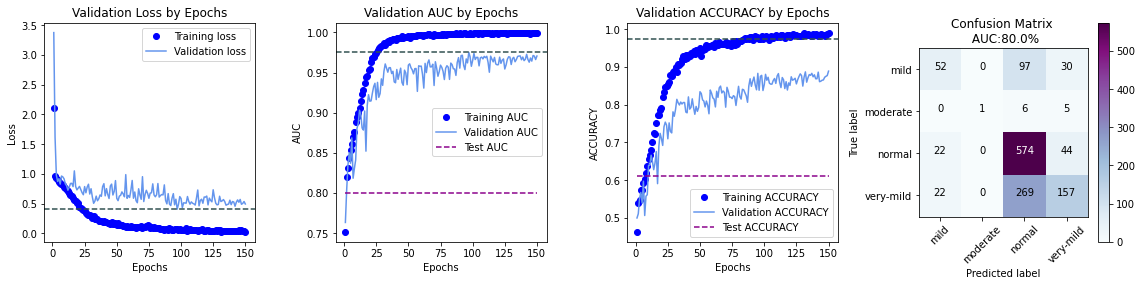

In [34]:
# get class predictions
y_prob = model_au.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot
plot_training_metrics(history_au,model_au,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])

# ResNet101V2 전이학습

In [26]:
# 학습에 필요한 파라미터
EPOCHS        = 120
early_stoping = EarlyStopping(monitor = 'val_accuracy',patience = 15,restore_best_weights=True)
reduce_lr     = ReduceLROnPlateau(monitor='val_loss',factor=0.9, patience=15, min_lr=1e-20, verbose=1, cooldown=3)
callbacks     = [early_stoping]
metrics       = [tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.CategoricalAccuracy(name='accuracy')]

2021-10-28 19:14:43.088845: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 19:14:43.196539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2021-10-28 19:14:43.196577: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-10-28 19:14:43.197352: I tensorflow/core/platform/cpu_feature_g

In [27]:
# 모델 형성
# 전이학습할 모델(InceptionV3)
# Train Model: Base + Optimized Hyperparameters + Data Augmentation
conv_base = tf.keras.applications.resnet_v2.ResNet101V2(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model_au = build_transfer_model(conv_base,dropout=0.5,conv_nodes=1024,dense_node =1024,learn_rate=0.005,metric=metrics)


# 학습
tic = time.perf_counter()
history_au = model_au.fit(
    train_gen_au,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
    callbacks        = callbacks  # early stopping 
)

# 모델 저장
model_au.save(os.path.join(DIR_MODELS,'model_base_ResNet101V2'))

# 학습에 걸린 시간
toc = time.perf_counter()
print("Total Time:{} mins".format(round((toc-tic)/60,2)))

No Layers Trainable: Using Base Model Weights


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 6, 7, 2048)        42626560  
_________________________________________________________________
dropout (Dropout)            (None, 6, 7, 2048)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 7, 2048)        8192      
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 7, 1024)        18875392  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 7, 1024)        9438208   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 1024)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 1024)        0

2021-10-28 19:15:07.393061: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/120
56/56 - 242s - loss: 4.9317 - auc: 0.7299 - accuracy: 0.4597 - val_loss: 1.3830 - val_auc: 0.7905 - val_accuracy: 0.4993
Epoch 2/120
56/56 - 234s - loss: 1.0321 - auc: 0.7906 - accuracy: 0.4960 - val_loss: 1.0039 - val_auc: 0.8069 - val_accuracy: 0.4993
Epoch 3/120
56/56 - 233s - loss: 1.0101 - auc: 0.8000 - accuracy: 0.4990 - val_loss: 0.9689 - val_auc: 0.8217 - val_accuracy: 0.5306
Epoch 4/120
56/56 - 234s - loss: 0.9854 - auc: 0.8117 - accuracy: 0.5174 - val_loss: 0.9346 - val_auc: 0.8310 - val_accuracy: 0.5390
Epoch 5/120
56/56 - 233s - loss: 0.9465 - auc: 0.8254 - accuracy: 0.5364 - val_loss: 0.8972 - val_auc: 0.8381 - val_accuracy: 0.5403
Epoch 6/120
56/56 - 232s - loss: 0.9073 - auc: 0.8372 - accuracy: 0.5521 - val_loss: 0.8969 - val_auc: 0.8439 - val_accuracy: 0.5592
Epoch 7/120
56/56 - 233s - loss: 0.9122 - auc: 0.8386 - accuracy: 0.5688 - val_loss: 0.8888 - val_auc: 0.8423 - val_accuracy: 0.5390
Epoch 8/120
56/56 - 230s - loss: 0.9112 - auc: 0.8395 - accuracy: 0.5

2021-10-29 01:16:44.786446: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./Ryu/models/model_base_ResNet101V2/assets


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Total Time:362.06 mins



 Model AUC on Test Data:88.0%

 Model ACCURACY on Test Data:64.0%
-----------------------------------
              precision    recall  f1-score   support

        mild       0.48      0.35      0.40       179
    moderate       0.45      0.42      0.43        12
      normal       0.79      0.67      0.72       640
   very-mild       0.55      0.74      0.63       448

    accuracy                           0.64      1279
   macro avg       0.57      0.54      0.55      1279
weighted avg       0.66      0.64      0.64      1279



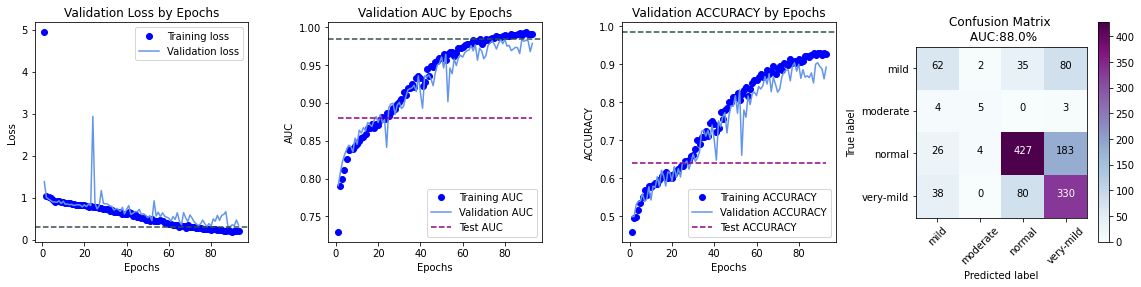

In [ ]:
# get class predictions
y_prob = model_au.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot
plot_training_metrics(history_au,model_au,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])

# ResNet152V2 전이학습

In [ ]:
# 모델 형성
# 전이학습할 모델(InceptionV3)
# Train Model: Base + Optimized Hyperparameters + Data Augmentation
conv_base = tf.keras.applications.resnet_v2.ResNet152V2(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model_au = build_transfer_model(conv_base,dropout=0.5,conv_nodes=1024,dense_node =1024,learn_rate=0.005,metric=metrics)


# 학습
tic = time.perf_counter()
history_au = model_au.fit(
    train_gen_au,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
    callbacks        = callbacks  # early stopping 
)

# 모델 저장
model_au.save(os.path.join(DIR_MODELS,'model_base_ResNet152V2'))

# 학습에 걸린 시간
toc = time.perf_counter()
print("Total Time:{} mins".format(round((toc-tic)/60,2)))

234561536/234545216 [==============================] - 9s 0us/step
No Layers Trainable: Using Base Model Weights


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 6, 7, 2048)        58331648  
_________________________________________________________________
dropout (Dropout)            (None, 6, 7, 2048)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 7, 2048)        8192      
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 7, 1024)        18875392  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 7, 1024)        9438208   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 1024)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 1024)        0

In [ ]:
# get class predictions
y_prob = model_au.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot
plot_training_metrics(history_au,model_au,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])

# VGG19 전이학습

In [ ]:
# 모델 형성
# 전이학습할 모델(InceptionV3)
# Train Model: Base + Optimized Hyperparameters + Data Augmentation
conv_base = tf.keras.applications.vgg19.VGG19(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model_au = build_transfer_model(conv_base,dropout=0.5,conv_nodes=1024,dense_node =1024,learn_rate=0.005,metric=metrics)


# 학습
tic = time.perf_counter()
history_au = model_au.fit(
    train_gen_au,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
    callbacks        = callbacks  # early stopping 
)

# 모델 저장
model_au.save(os.path.join(DIR_MODELS,'model_base_VGG19'))

# 학습에 걸린 시간
toc = time.perf_counter()
print("Total Time:{} mins".format(round((toc-tic)/60,2)))

In [ ]:
# get class predictions
y_prob = model_au.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot
plot_training_metrics(history_au,model_au,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])

# Xception 전이학습

In [ ]:
# 모델 형성
# 전이학습할 모델(InceptionV3)
# Train Model: Base + Optimized Hyperparameters + Data Augmentation
conv_base = tf.keras.applications.xception.Xception(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model_au = build_transfer_model(conv_base,dropout=0.5,conv_nodes=1024,dense_node =1024,learn_rate=0.005,metric=metrics)


# 학습
tic = time.perf_counter()
history_au = model_au.fit(
    train_gen_au,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
    callbacks        = callbacks  # early stopping 
)

# 모델 저장
model_au.save(os.path.join(DIR_MODELS,'model_base_Xception'))

# 학습에 걸린 시간
toc = time.perf_counter()
print("Total Time:{} mins".format(round((toc-tic)/60,2)))

In [ ]:
# get class predictions
y_prob = model_au.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot
plot_training_metrics(history_au,model_au,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])